In [1]:
import os
import pickle
# Gmail API utils
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
# for encoding/decoding messages in base64
from base64 import urlsafe_b64decode, urlsafe_b64encode
# for dealing with attachement MIME types
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.image import MIMEImage
from email.mime.audio import MIMEAudio
from email.mime.base import MIMEBase
from mimetypes import guess_type as guess_mime_type

SCOPES = ['https://mail.google.com/']
our_email = 'corsilt1230@gmail.com'



def search_messages(service, query):
    result = service.users().messages().list(userId='me',q=query).execute()
    messages = [ ]
    if 'messages' in result:
        messages.extend(result['messages'])
    while 'nextPageToken' in result:
        page_token = result['nextPageToken']
        result = service.users().messages().list(userId='me',q=query, pageToken=page_token).execute()
        if 'messages' in result:
            messages.extend(result['messages'])
    return messages

def gmail_authenticate():
    creds = None
    # the file token.pickle stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first time
    if os.path.exists("token.pickle"):
        with open("token.pickle", "rb") as token:
            creds = pickle.load(token)
    # if there are no (valid) credentials availablle, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        # save the credentials for the next run
        with open("token.pickle", "wb") as token:
            pickle.dump(creds, token)
    return build('gmail', 'v1', credentials=creds)

# get the Gmail API service
service = gmail_authenticate()

ids = search_messages(service, 'job application OR your submission')

In [2]:
def search_messages(service, query):
    result = service.users().messages().list(userId='me',q=query).execute()
    messages = [ ]
    if 'messages' in result:
        messages.extend(result['messages'])
    while 'nextPageToken' in result:
        page_token = result['nextPageToken']
        result = service.users().messages().list(userId='me',q=query, pageToken=page_token).execute()
        if 'messages' in result:
            messages.extend(result['messages'])
    return messages

In [3]:
def read_message(service, message):
    """
    This function takes Gmail API `service` and the given `message_id` and does the following:
        - Downloads the content of the email
        - Prints email basic information (To, From, Subject & Date) and plain/text parts
        - Creates a folder for each email based on the subject
        - Downloads text/html content (if available) and saves it under the folder created as index.html
        - Downloads any file that is attached to the email and saves it in the folder created
    """
    msg = service.users().messages().get(userId='me', id=message['id'], format='full').execute()
    # parts can be the message body, or attachments
    payload = msg['payload']
    headers = payload.get("headers")
    parts = payload.get("parts")
    folder_name = "email"
    has_subject = False
    if headers:
        # this section prints email basic info & creates a folder for the email
        for header in headers:
            name = header.get("name")
            value = header.get("value")
            if name.lower() == 'from':
                # we print the From address
                print("From:", value)
            if name.lower() == "to":
                # we print the To address
                print("To:", value)
            if name.lower() == "subject":
                # make our boolean True, the email has "subject"
                has_subject = True
                # make a directory with the name of the subject
                folder_name = clean(value)
                # we will also handle emails with the same subject name
                folder_counter = 0
                while os.path.isdir(folder_name):
                    folder_counter += 1
                    # we have the same folder name, add a number next to it
                    if folder_name[-1].isdigit() and folder_name[-2] == "_":
                        folder_name = f"{folder_name[:-2]}_{folder_counter}"
                    elif folder_name[-2:].isdigit() and folder_name[-3] == "_":
                        folder_name = f"{folder_name[:-3]}_{folder_counter}"
                    else:
                        folder_name = f"{folder_name}_{folder_counter}"
                os.mkdir(folder_name)
                print("Subject:", value)
            if name.lower() == "date":
                # we print the date when the message was sent
                print("Date:", value)
    if not has_subject:
        # if the email does not have a subject, then make a folder with "email" name
        # since folders are created based on subjects
        if not os.path.isdir(folder_name):
            os.mkdir(folder_name)
    parse_parts(service, parts, folder_name, message)
    print("="*50)

In [5]:
results = search_messages(service, "thank you for applying OR your submission OR thank you for your interest'")
# for each email matched, read it (output plain/text to console & save HTML and attachments)
# for msg in results:
#     read_message(service, msg)

In [6]:
emails = search_messages(service, '')

In [7]:
def get_subjects(service, ids):
  results = []
  for i in ids:
    v = service.users().messages().get(userId="me", id=i, format="full", metadataHeaders=None).execute()
    headers=v["payload"]["headers"]
    subject= [i['value'] for i in headers if i["name"]=="Subject"]
    results.extend(subject)

  return results

In [9]:
ids = search_messages(service, 'after:2022/01/24')

In [10]:
import re
pat = re.compile(r'(?i)(job)|(application)|(interest)|(applying)')

#(?i)(job)*(application)*(interest)*(applying)*

In [11]:
dd= get_subjects(service, [d['id'] for d in ids])

In [12]:
f = [i for i in dd if pat.search(i)]
subjects = [x for x in f if not re.search(r'(?i)(jobs)',x)]

In [13]:
def look_up_ids(service, subjects, original_ids):
    results = []
    ids = [k['id'] for k in original_ids]
    #return ids
    for i in ids:
      v = service.users().messages().get(userId="me", id=i, format="full", metadataHeaders=None).execute()
      headers=v["payload"]["headers"]
      subject= [(x['value'],i) for x in headers if x["name"]=="Subject"]
      #return subject
      for j in subject:
        if j[0] in subjects:
          results.append(j[1])

    return results

In [14]:
filtered_ids = look_up_ids(service, subjects, ids)

In [15]:
def get_dates(service, ids):
  from datetime import datetime
  results = []
  for z in ids:
    v = service.users().messages().get(userId="me", id=z, format="full", metadataHeaders=None).execute()
    headers=v["payload"]["headers"]
    subject= [i['value'] for i in headers if i["name"]== "Date"]
    try:
      temp = subject[0].split(',')[1].strip()
    except:
      temp = subject[0].strip()
    try:
      date = datetime.strptime(temp, '%d %b %Y %H:%M:%S %z')
    except:
      date = datetime.strptime(temp[0:-5], '%d %b %Y %H:%M:%S %z ')
    results.append(date)

  return results

In [16]:
t = get_dates(service, filtered_ids)

In [17]:
dat = [i.strftime('%m-%d-%Y') for i in t]

In [18]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt


In [19]:
data = Counter(dat)
ser = pd.Series(dict(data))

In [20]:
def make_bar_chart(x, y):
    import numpy as np
    from matplotlib.ticker import StrMethodFormatter
    from matplotlib.ticker import FuncFormatter

    bar_width = 0.25 # the width of the bars
    plots = []
    opacity = 0.8


    fig = plt.subplots()
    #fig, axs = plt.subplots(2, 1)
    ax = plt.gca()
    rects = ax.bar(x= x, height=y,
                    alpha=opacity, color='#5eeb34',
                    label=str('daily'))

    plt.xticks(rotation=77, )
    plt.xlabel('Dates', size=24, rotation=0, labelpad=40)
    plt.title('First DS job search',size=18,pad=10)
    plt.ylabel('Job Applications Sent', size=20)
    plt.grid(b=True, axis='y')
    #ax.yaxis.set_major_formatter(formatter)
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + 0 + rect.get_width()/2., height + 0.1,
        '{:.0f}'.format(height),
        ha='center', va='bottom', rotation=0)

    ser2 = np.cumsum(ser)
    ax2 = ax.twinx()
    ax2.plot(ser2, label='total')
    ax2.set_ylabel('cumulative count', size=20, rotation=-90,labelpad=20)

    plt.gcf().set_size_inches(20,7)
    plt.legend()
    plots.append(fig)
    plt.show()
    plt.close()  #used to not generate plots automatically all are stored in list
    # return fig

In [21]:
ser = ser.sort_index(ascending=True)

C:\Users\cbilyeu\AppData\Local\Temp\ipykernel_26200\1824713086.py:22: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, axis='y')


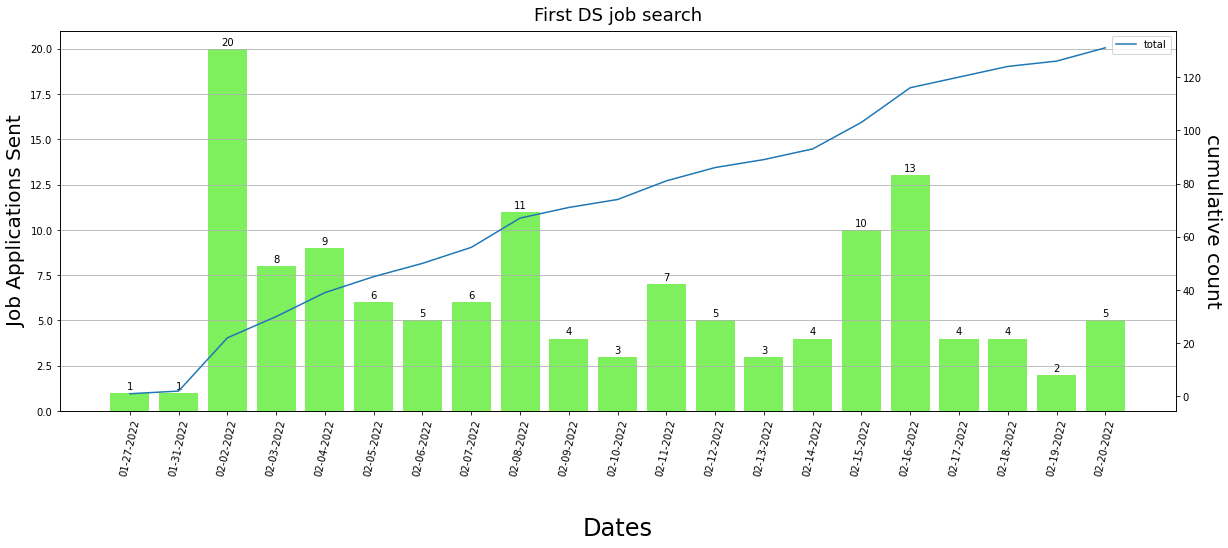

In [22]:
make_bar_chart(ser.index, ser)

### to do
- add subplot for rejection and initial contacts, and interviews

In [23]:
import random

In [24]:
contacts = pd.Series([random.randint(0,3) for i in ser.index], index=ser.index)
interviews = pd.Series([random.randint(0,3) for i in ser.index], index=ser.index)
rejections = pd.Series([random.randint(0,3) for i in ser.index], index=ser.index)

In [25]:
df = pd.DataFrame(ser).reset_index()
df['index'] = pd.to_datetime(df['index'])
df['month'] = df['index'].dt.month

month_dict = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr'}

df['month'] = df['month'].replace(month_dict)

In [26]:
def make_bar_chart(x, y, a,b,c):
    import numpy as np
    from matplotlib.ticker import StrMethodFormatter
    from matplotlib.ticker import FuncFormatter
    import matplotlib.ticker as ticker

    bar_width = 0.25 # the width of the bars
    plots = []
    opacity = 0.8


    fig, ax = plt.subplots(2, 1, figsize=(20,7), gridspec_kw={'height_ratios': [2, 1]}, )
    fig.subplots_adjust(hspace=0.1)

    rects = ax[0].bar(x= x, height=y,
                    alpha=opacity, color='#5eeb34',
                    label=str('daily'))

    #ax[0].set_xticks(x,rotation=77,)

    ax[0].set_title('First DS job search',size=18,pad=15)
    ax[0].set_ylabel('Daily Applications Sent', size=20)
    #ax[0].set_xticklabels(  rotation=77,)
    ax[0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    ax[0].grid(b=True, axis='y')
    #ax.yaxis.set_major_formatter(formatter)
    for rect in rects:
        height = rect.get_height()
        ax[0].text(rect.get_x() + 0 + rect.get_width()/2., height + 0.1,
        '{:.0f}'.format(height),
        ha='center', va='bottom', rotation=0)

    ser2 = np.cumsum(ser)
    ax2 = ax[0].twinx()
    ax2.plot(ser2, label='total')
    ax2.set_ylabel('cumulative count', size=20, rotation=-90,labelpad=20)
    lines, labels = ax[0].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax[0].legend(lines + lines2, labels + labels2, loc=0)


    ax[1].plot(a,label='contacts',c='black')
    ax[1].plot(b,label='interviews',)
    ax[1].plot(c,label='rejections',c='r')
    ax[1].xaxis.set_major_locator(ticker.MultipleLocator(5.0))
    ax[1].xaxis.set_minor_locator(ticker.MultipleLocator(1))
    majors = ['']+ list(df['month'][::4])
    ax[1].xaxis.set_major_formatter(ticker.FixedFormatter(majors))
    minors = [""] 

    ax[1].xaxis.set_minor_formatter(ticker.FixedFormatter(minors))
    # ax[1].set_xticks(range(len(ser.index))[::4],  rotation=77,)
    # ax[1].set_xticklabels(labels=(df['month'][::4]),  rotation=77,)
    ax[1].set_ylabel('Daily Count', size=10)
    ax[1].legend()
    plots.append(fig)
    plt.show()
    plt.close()  #used to not generate plots automatically all are stored in list
    # return fig

In [27]:
['']+ list(df['month'][::4])

['', 'Jan', 'Feb', 'Feb', 'Feb', 'Feb', 'Feb']

C:\Users\cbilyeu\AppData\Local\Temp\ipykernel_26200\1288557010.py:30: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax[0].grid(b=True, axis='y')
C:\Users\cbilyeu\AppData\Local\Temp\ipykernel_26200\1288557010.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].xaxis.set_major_formatter(ticker.FixedFormatter(majors))
C:\Users\cbilyeu\AppData\Local\Temp\ipykernel_26200\1288557010.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].xaxis.set_minor_formatter(ticker.FixedFormatter(minors))


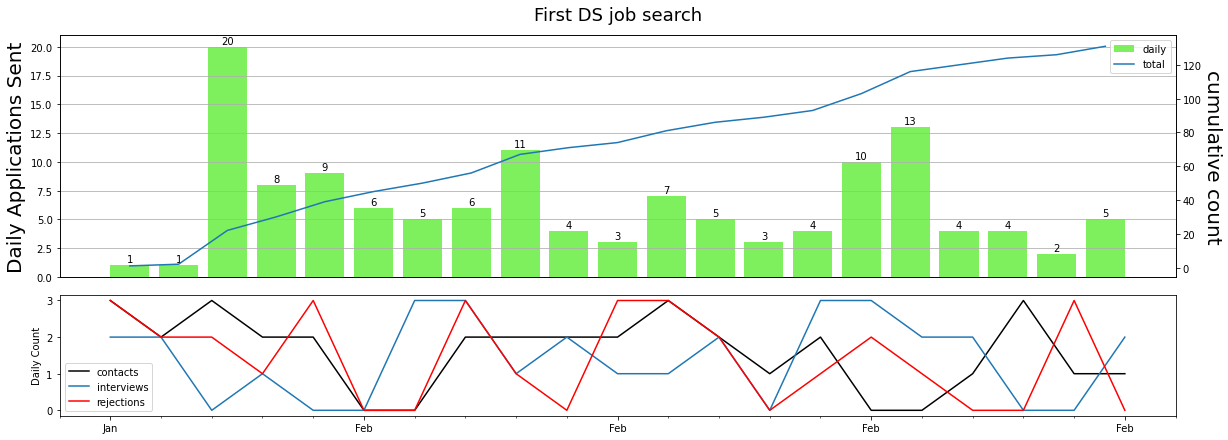

In [28]:
make_bar_chart(ser.index, ser,contacts, interviews, rejections)

In [29]:
result = service.users().messages().list(userId='me',q='after:2022/01/24 (regret to inform you) OR (not be moving forward)').execute()

In [30]:
ids = [i['id'] for i in result['messages']]

In [31]:
ids

['17f0c9d93d632210',
 '17efeeca383e56a9',
 '17ef3ef614de13e4',
 '17edaf102dfa80a7',
 '17edae0634c18e69',
 '17eda3e553e7b333',
 '17ec911458ef6c46',
 '17ec68ae20db85cd',
 '17e8b02b7403969f']

In [32]:
dd= get_subjects(service, ids)

In [33]:
subjects = [i for i in dd if pat.search(i)]
# subjects = [x for x in f if not re.search(r'(?i)(jobs)',x)]

In [34]:
f

['Jobs like Software Engineer, Machine Learning (ML)',
 'MACHINE LEARNING SOFTWARE ENGINEER jobs in NEW YORK',
 'Congrats on your application for the Machine Learning Engineer at Twitter!',
 'Welcome to ZipRecruiter - Your job search made easy',
 'Kforce Application Confirmation - Job 1144~EQG~2006865T1~99',
 'Thank you for applying to Odeko',
 'Thank you for applying to Atlassian',
 'RL Software Engineer, Machine Learning at Meta and 3 more jobs in Seattle, WA for you. Apply Now.',
 'Machine Learning Engineer at CyberCoders and 3 more jobs in Washington State, US for you. Apply Now.',
 'Your application status update from February 5',
 'Thank you for your interest and applying to Instabase',
 'Machine Learning Engineer at CyberCoders and 3 more jobs in Seattle, WA for you. Apply Now.',
 'Principal Machine Learning Engineer at Expedia Group and 3 more jobs in Washington State, US for you. Apply Now.',
 'Come Back And Apply To These Jobs',
 'Thank you for applying to Socure',
 'Thank yo

In [35]:
def look_up_ids(service, subjects, original_ids):
    results = []
    # ids = [k['id'] for k in original_ids]
    #return ids
    for i in ids:
      v = service.users().messages().get(userId="me", id=i, format="full", metadataHeaders=None).execute()
      headers=v["payload"]["headers"]
      subject= [(x['value'],i) for x in headers if x["name"]=="Subject"]
      #return subject
      for j in subject:
        if j[0] in subjects:
          results.append(j[1])

    return results

In [36]:
filtered_ids = look_up_ids(service, subjects, ids)

In [37]:
def get_dates(service, ids):
  from datetime import datetime
  results = []
  for z in ids:
    v = service.users().messages().get(userId="me", id=z, format="full", metadataHeaders=None).execute()
    headers=v["payload"]["headers"]
    subject= [i['value'] for i in headers if i["name"]== "Date"]
    try:
      temp = subject[0].split(',')[1].strip()
    except:
      temp = subject[0].strip()
    try:
      date = datetime.strptime(temp, '%d %b %Y %H:%M:%S %z')
    except:
      date = datetime.strptime(temp[0:-5], '%d %b %Y %H:%M:%S %z ')
    results.append(date)

  return results

In [38]:
t = get_dates(service, filtered_ids)

In [39]:
dat = [i.strftime('%m-%d-%Y') for i in t]

In [40]:
d = dict(Counter(dat))

In [41]:
df['rejection'] = df['index'].replace(d)

In [42]:
df['rejection'] = pd.to_numeric(df['rejection'], errors='coerce').fillna(0)

In [43]:
df['interview'] = 0

In [44]:
df = df.set_index(df['index'])
df.loc['2022-02-08','interview'] = 1
df.loc['2022-02-16','interview'] = 1

In [45]:
def make_bar_chart(x, y, a,b):
    import numpy as np
    from matplotlib.ticker import StrMethodFormatter
    from matplotlib.ticker import FuncFormatter
    import matplotlib.ticker as ticker

    bar_width = 0.25 # the width of the bars
    plots = []
    opacity = 0.8


    fig, ax = plt.subplots(2, 1, figsize=(20,7), gridspec_kw={'height_ratios': [2, 1]}, )
    fig.subplots_adjust(hspace=0.1)

    rects = ax[0].bar(x= x, height=y,
                    alpha=opacity, color='#5eeb34',
                    label=str('daily'))

    #ax[0].set_xticks(x,rotation=77,)

    ax[0].set_title('First DS job search',size=18,pad=15)
    ax[0].set_ylabel('Daily Applications Sent', size=20)
    #ax[0].set_xticklabels(  rotation=77,)
    ax[0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    ax[0].grid(b=True, axis='y')
    #ax.yaxis.set_major_formatter(formatter)
    for rect in rects:
        height = rect.get_height()
        ax[0].text(rect.get_x() + 0 + rect.get_width()/2., height + 0.1,
        '{:.0f}'.format(height),
        ha='center', va='bottom', rotation=0)

    ser2 = np.cumsum(ser)
    ax2 = ax[0].twinx()
    ax2.plot(ser2, label='total')
    ax2.set_ylabel('cumulative count', size=20, rotation=-90,labelpad=20)
    lines, labels = ax[0].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax[0].legend(lines + lines2, labels + labels2, loc=0)

    ax[1].tick_params(which='major', width=1.00, length=6.5)
    ax[1].tick_params(which='minor', width=0.75, length=3, labelsize=14)
    ax[1].plot(b,label='interviews',)
    ax[1].plot(a,label='rejections',c='r')
    ax[1].xaxis.set_major_locator(ticker.LinearLocator(5))
    ax[1].xaxis.set_minor_locator(ticker.LinearLocator(20))
    majors = list(df['month'][::4])
    ax[1].xaxis.set_major_formatter(ticker.FixedFormatter(majors),)
    minors = [""] 

    ax[1].xaxis.set_minor_formatter(ticker.FixedFormatter(minors))
    # ax[1].set_xticks(range(len(ser.index))[::4],  rotation=77,)
    # ax[1].set_xticklabels(labels=(df['month'][::4]),  rotation=77,)
    ax[1].set_ylabel('Daily Count', size=10)
    ax[1].legend()

    for axis in [ax[0].yaxis, ax[1].yaxis]:
      axis.set_major_locator(ticker.MaxNLocator(integer=True))
    plots.append(fig)
    plt.show()
    plt.close()  #used to not generate plots automatically all are stored in list
    # return fig

C:\Users\cbilyeu\AppData\Local\Temp\ipykernel_26200\2763972258.py:30: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax[0].grid(b=True, axis='y')
C:\Users\cbilyeu\AppData\Local\Temp\ipykernel_26200\2763972258.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].xaxis.set_major_formatter(ticker.FixedFormatter(majors),)
C:\Users\cbilyeu\AppData\Local\Temp\ipykernel_26200\2763972258.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].xaxis.set_minor_formatter(ticker.FixedFormatter(minors))


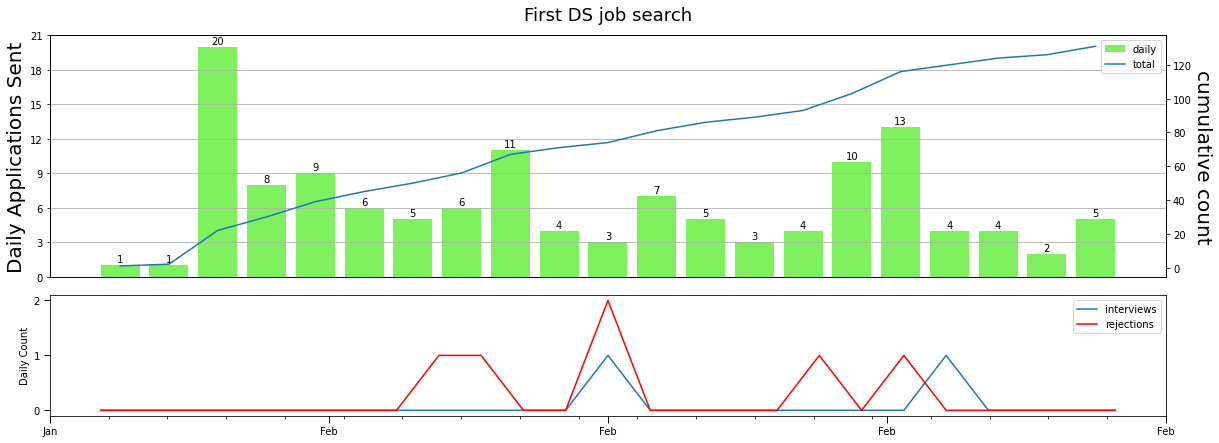

In [46]:
make_bar_chart(ser.index, ser,df['rejection'], df['interview'])